In [220]:
import pandas as pd
import math, time, datetime
from dateutil.parser import parse
import dateutil
import locale
locale.setlocale(locale.LC_ALL, 'en_US')
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [223]:
df_viol = pd.read_csv('violations.csv', nrows=1000000, dtype={17:str, 18:str, 20:str, 21:str, 22:str, 23:str, 29:str, 30:str, 31:str, 32:str, 36:str, 38:str, 39:str})

In [224]:
#1
count = 0
def is_string(value):
    global count
    if isinstance(value, str):
        return value
    else:
        count += 1
        return str(value)
    
not_string = df_viol[df_viol['Plate ID'].apply(is_string) != True]
print(count, "Plate ID converted to strings.")

#2
df_viol[df_viol['Vehicle Year'] == 0] = math.nan
df_viol

#3

date_columns = ['Issue Date', 'Vehicle Expiration Date', 'Date First Observed']
for column in date_columns:
    print("Parsing “" + column + "”…")
    pd.to_datetime(df_viol[column])
    print("“" + column +"”: DONE\n")
    


491 Plate ID converted to strings.
Parsing “Issue Date”…
“Issue Date”: DONE

Parsing “Vehicle Expiration Date”…
“Vehicle Expiration Date”: DONE

Parsing “Date First Observed”…
“Date First Observed”: DONE



In [245]:
#4
def toDate(string):
    if isinstance(string, datetime.datetime): # already converted
        return
        
    if string != string: # == NaN
        return math.nan
    elif string == 0:
        return math.nan
    else:
        try:
            value = str(int(string))
            result = dateutil.parser.parse(value)
            if not result:
                print('! toDate(): Error while parsing', value, '-> value set to Nan.')
                return math.nan
            return result
        except ValueError:
            print('! toDate(): Error with string', string, '-> value set to NaN.')
            return math.nan

df_viol['Date First Observed'] = df_viol['Date First Observed'].apply(toDate)

#5
def toTime(string):
    if string != string: # NaN
        return
    if string[:2] == '00':
        string = '12' + string[2:]
    try:
        timestamp = time.strptime(string + 'M', '%I%M%p')
    except ValueError:
        print('! toTime(): Error with string', string, '-> value set to Nan.')
        return math.nan
    return time.strftime('%H:%M %p', timestamp)

df_viol['Violation Time'] = df_viol['Violation Time'].apply(toTime)

! toTime(): Error with string 09+4A -> value set to Nan.
! toTime(): Error with string 8545P -> value set to Nan.
! toTime(): Error with string 3244P -> value set to Nan.
! toTime(): Error with string 8400P -> value set to Nan.
! toTime(): Error with string 5913P -> value set to Nan.
! toTime(): Error with string 1533P -> value set to Nan.
! toTime(): Error with string 2805P -> value set to Nan.
! toTime(): Error with string 2045P -> value set to Nan.
! toTime(): Error with string .633P -> value set to Nan.
! toTime(): Error with string 2906P -> value set to Nan.
! toTime(): Error with string 5315P -> value set to Nan.
! toTime(): Error with string 4400P -> value set to Nan.
! toTime(): Error with string 1630P -> value set to Nan.
! toTime(): Error with string 092/A -> value set to Nan.
! toTime(): Error with string 7756P -> value set to Nan.
! toTime(): Error with string 042*A -> value set to Nan.
! toTime(): Error with string 4715P -> value set to Nan.
! toTime(): Error with string 8

In [253]:
#6

# Let's find and sort the colors
colors = list(set(df_viol['Vehicle Color'].tolist()))
colors = [i for i in colors if i == i and i != None] # we remove the NaN/None
colors.sort()
colors

def replace_color(color):    
    # Dictionary of tuples for the color replacements
    
    if color != color or color == None: # damn NaN
        return
    
    replacements = [
        (re.compile("^(BL|BK|BLK)$"), "BLACK"),
        (re.compile("^(GR|GRAY|GRY|GY)$"), "GREY"),
        (re.compile("^BLU$"), "BLUE"),
        (re.compile("^(BR|BRN|BRW|BRWN)$"), "BROWN"),
        (re.compile("^(GR|GRAY|GRY|GY)$"), "GREY"),
        (re.compile("^(W|WH|WHT)$"), "WHITE"),
        (re.compile("^RD$"), "RED"),
        (re.compile("^(SILVE|SILVR)$"), "SILVER")
    ]
    for rep in replacements:
        if color[0] == rep[1][0]: # we skip non-pertinent regexp for efficiency
            color = re.sub(rep[0], rep[1], color)
    return color

df_viol['Vehicle Color'] = df_viol['Vehicle Color'].apply(replace_color)

In [254]:
#7
df_codes = pd.read_csv('DOF_Parking_Violation_Codes.csv')

# a) solve the 37-38 issue:
## we duplicate the line
df_wrong = df_codes[ df_codes['CODE'] == '37-38']
df_codes = df_codes.append(df_wrong, ignore_index=True) 

## we change the value
rows = df_codes[ df_codes['CODE'] == '37-38'].index.tolist()
df_codes.set_value(rows[0], 'CODE', "37")
df_codes.set_value(rows[0], 'DEFINITION', "Parking in excess of the allowed time")
df_codes.set_value(rows[1], 'CODE', "38")
df_codes.set_value(rows[1], 'DEFINITION', "Failing to show a receipt or tag in the windshield")

# b) convert the code to an int
df_codes['Code_int'] = df_codes['CODE'].astype(int)
def toInt(value):
    if value == value:
        return int(value)
    else:
        return 0 # An int cannot be NaN
df_viol['Code_int'] = df_viol['Violation Code'].apply(toInt)

# Note: there's no "41" code in DOF_Parking_Violation_Codes.csv

df = df_viol.merge(df_codes, how='left', left_on='Code_int', right_on='Code_int')

In [255]:
# Make sure codes 37 & 38 were correctly updated
df_codes[(df_codes['Code_int'] == 37) | (df_codes['Code_int'] == 38)]

,CODE,DEFINITION,Manhattan 96th St. & below,All Other Areas,Code_int
23,37,Parking in excess of the allowed time,$65,$35,37
84,38,Failing to show a receipt or tag in the windsh...,$65,$35,38


In [256]:
#8
vary_count = 0

def priceToInt(value):
    global vary_count
    if value == value:
        if value == 'vary':
            vary_count += 1
            return math.nan
        elif value[:18] == '1st Offense - $265':
            return 265
        elif value[:16] == "100\n(Regular Tow":
            return 100
        elif value[:15] == "$200 (Heavy Tow":
            return 200
        try:
            return toInt(value[1:])
        except ValueError:
            print('! priceToInt(): Error with “' + str(value) + '” -> set to Nan.')
            return math.nan
    else:
        return 0
df['Manhattan_fine'] = df['Manhattan  96th St. & below'].apply(priceToInt)
df['Other_areas_fine'] = df['All Other Areas'].apply(priceToInt)

print(vary_count, "fields containing “vary” were set to NaN. \n\n~~~ \n")

print("(8) NYC made at least", "$" + locale.format("%d", df['Other_areas_fine'].sum(), grouping=True), "in parking violations.")

#9
max_fine_idx = df['Manhattan_fine'].idxmax()
print("The most lucrative fine is $" + str(df.iloc[max_fine_idx]['Manhattan_fine']), "and has following definition: “" + df.iloc[max_fine_idx]['DEFINITION'] + "”.")

df_codes = df[df['Code_int'] != 0] # we skip the "NaN" code
count = df_codes['Code_int'].value_counts()
tuples = [tuple((x, y)) for x, y in count.items()]
most_frequent_violation_definition = df_codes[df_codes['Code_int'] == tuples[0][0]].iloc[0]['DEFINITION']
most_frequent_violation_definition2 = df_codes[df_codes['Code_int'] == tuples[1][0]].iloc[1]['DEFINITION']

print("(9a) The most frequent type of violation, with", tuples[0][1], "occurences, is: “" + most_frequent_violation_definition + "”.")

print("(9b) The most frequent type of _parking_ violation, with", tuples[1][1], "occurences, is in fact: “" + most_frequent_violation_definition2 + "”.")

#10
no_ny = df[(df['Registration State'] != 'NY') & (df['Registration State'] == df['Registration State'])]

print("(10) NYC makes at least", locale.format("%d", no_ny['Other_areas_fine'].sum(), grouping=True), "dollars off of all non-New York vehicles.")



! priceToInt(): Error with “2nd Offense - $265
2nd Offense - $515” -> set to Nan.
! priceToInt(): Error with “2nd Offense - $265
2nd Offense - $515” -> set to Nan.
! priceToInt(): Error with “2nd Offense - $265
2nd Offense - $515” -> set to Nan.
! priceToInt(): Error with “2nd Offense - $265
2nd Offense - $515” -> set to Nan.
! priceToInt(): Error with “2nd Offense - $265
2nd Offense - $515” -> set to Nan.
1334 fields containing “vary” were set to NaN. 

~~~ 

(8) NYC made at least $50,656,220 in parking violations.
The most lucrative fine is $265.0 and has following definition: “Parking a tractor-trailer on a residential street between 9PM and 5AM.”.
(9a) The most frequent type of violation, with 93737 occurences, is: “Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.”.
(9b) The most frequent type of _parking_ violation, with 90300 occurences, is in fact: “Failing to show a receipt or tag in the windshield”.
(10) NYC makes at l

(11a) The five most common fines (amount):


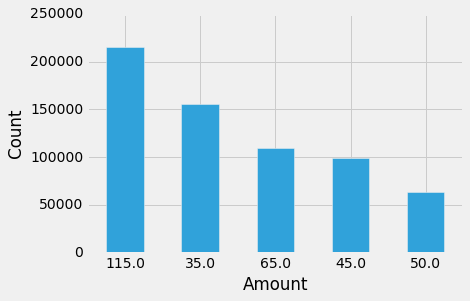

In [257]:
#11

df_codes[df_codes['Other_areas_fine'] > 0]['Other_areas_fine'].value_counts().head(5).plot(kind='bar')

plt.xticks(rotation=0)
plt.ylabel('Count')
plt.xlabel('Amount')


print("(11a) The five most common fines (amount):")

(11b) The five most common fines (definition):


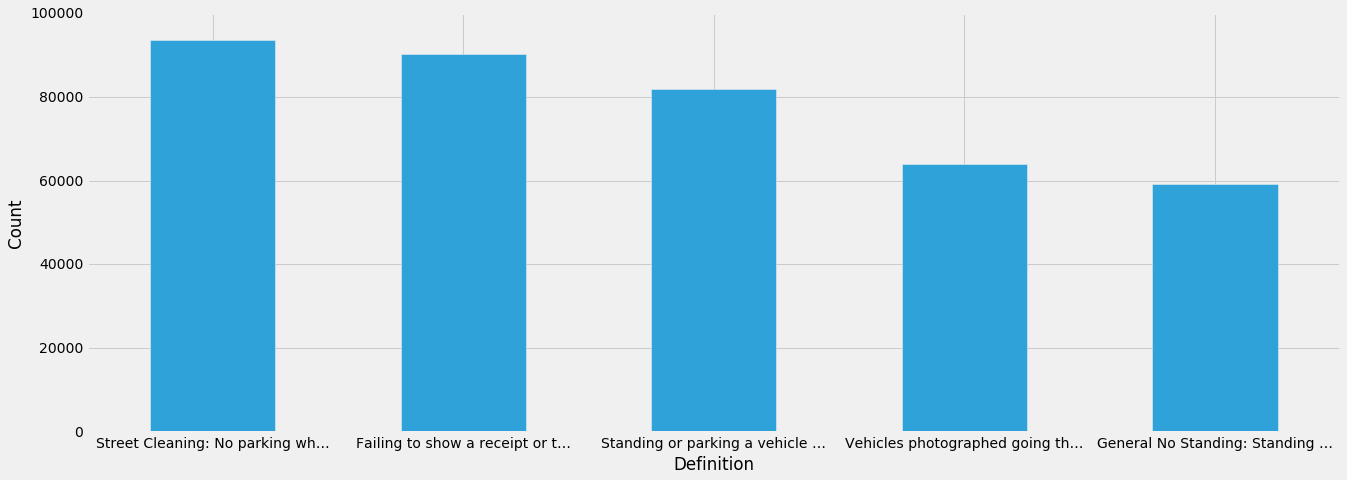

In [258]:
def shorten(text):
    if text == text:
        return text[:30] + "…"
    else:
        return math.nan

df['Short_def'] = df['DEFINITION'].apply(shorten)

df['Short_def'].value_counts().head(5).plot(kind='bar')

fig = plt.gcf()
fig.set_size_inches(20, 7, forward=True)

plt.ylabel('Count')
plt.xlabel('Definition')

plt.xticks(rotation=0)

print("(11b) The five most common fines (definition):")

(12a) 24 hours graph:


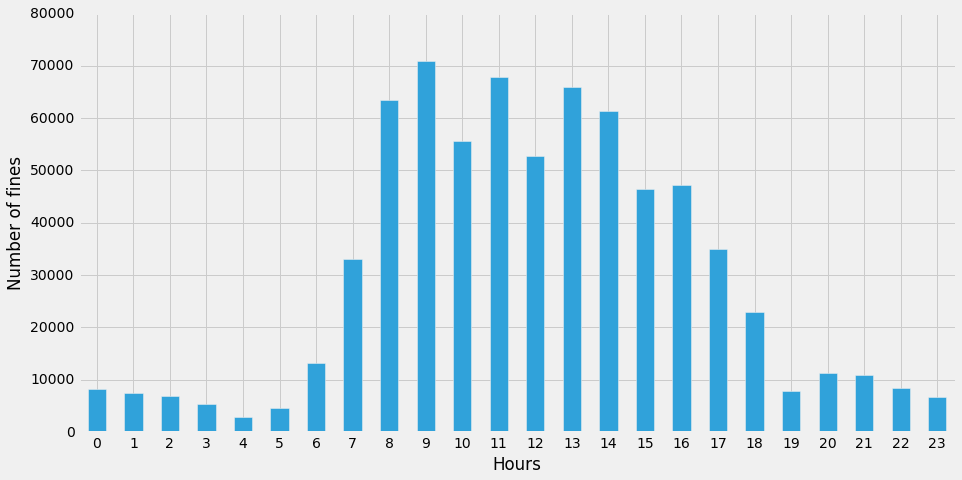

In [261]:
#12

# a) 24 hours graph
def timeToHour(time):
    if time == time and time != None and time[0] != '.':
        hour = int(time[:2])
        if hour < 24:
            return hour


fig = plt.gcf()
fig.set_size_inches(14, 7, forward=True)

viol_times = df[df['Violation Time'] == df['Violation Time']]
plt.style.use('fivethirtyeight')
hours_graph = viol_times['Violation Time'].apply(timeToHour).value_counts(sort=False).plot(kind='bar')
plt.ylabel('Number of fines')
plt.xlabel('Hours')
plt.xticks(rotation=0)
print("(12a) 24 hours graph:")

(12b) Time blocks graph:


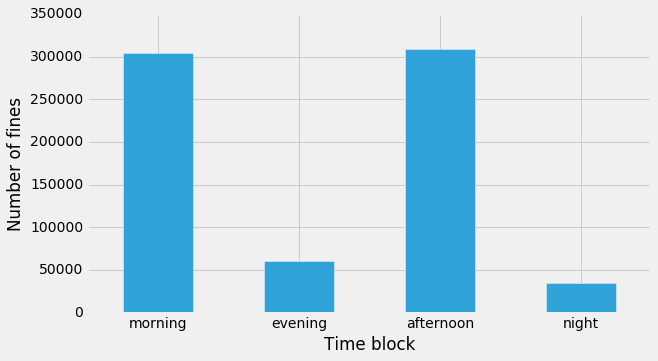

In [262]:
# b) 4 blocks graph
def timeToPeriod(time):
    if time == time and time != None:
        h = int(time[:2])
        if h < 6:
            return 'night'
        elif h < 12:
            return 'morning'
        elif h < 18:
            return 'afternoon'
        elif h < 23:
            return 'evening'
        else:
            pass
            #return 'Wrong time string'

fig = plt.gcf()
fig.set_size_inches(9, 5, forward=True)
hours_graph = viol_times['Violation Time'].apply(timeToPeriod).value_counts(sort=False).plot(kind='bar')
plt.ylabel('Number of fines')
plt.xlabel('Time block')
plt.xticks(rotation=0)
print("(12b) Time blocks graph:")

In [263]:
#13
mean = df['Other_areas_fine'].mean()
print("(13) The average ticket cost in NYC is", "%.2f" % df['Other_areas_fine'].mean() + " dollars.")


(13) The average ticket cost in NYC is 50.69 dollars.


(14) Number of tickets, daily graph:


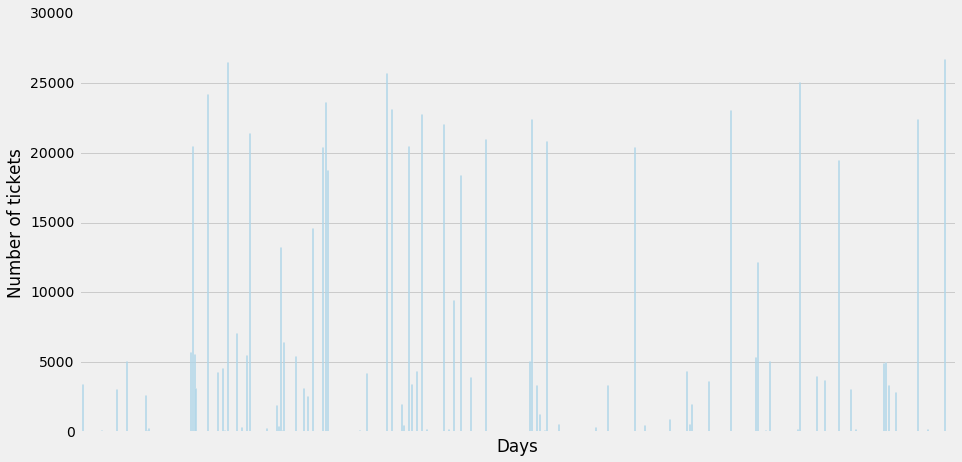

In [264]:
#14
fig = plt.gcf()
fig.set_size_inches(14, 7, forward=True)

viol_dates = df[df['Issue Date'] == df['Issue Date']]
plt.style.use('fivethirtyeight')
hours_graph = viol_dates['Issue Date'].value_counts(sort=False).plot(kind='bar')
plt.ylabel('Number of tickets')
plt.xlabel('Days')
plt.xticks([])
print("(14) Number of tickets, daily graph:")

(15) Amount, daily graph:


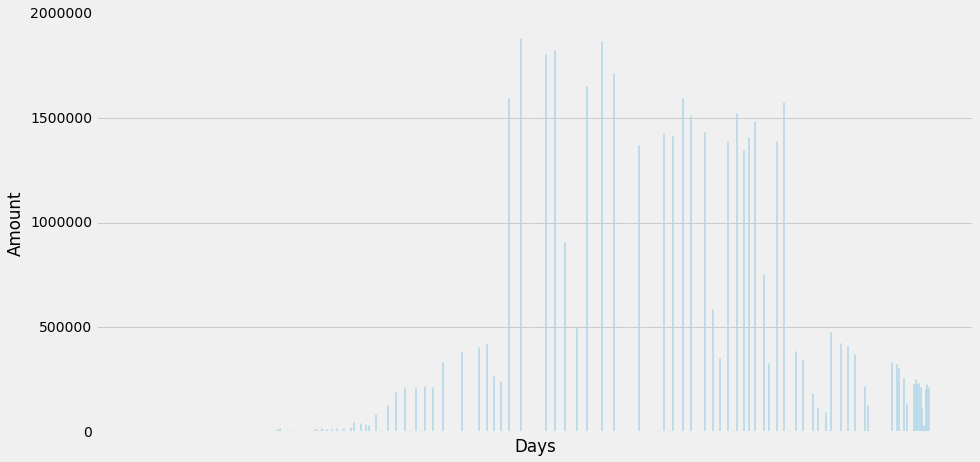

In [265]:
#15
#viol_dates = df[df['Issue Date'] == df['Issue Date']]
viol_dates = df[df['Issue Date'] == df['Issue Date']]
date_groups = viol_dates.groupby('Issue Date')

fig = plt.gcf()
fig.set_size_inches(14, 7, forward=True)

plt.style.use('fivethirtyeight')
hours_graph = date_groups['Other_areas_fine'].sum().plot(kind='bar')
plt.ylabel('Amount')
plt.xlabel('Days')
plt.xticks([])
print("(15) Amount, daily graph:")



In [267]:
#16
set(df_viol[df_viol['Registration State'] == 'NY']['Violation County'].tolist()) # to get the county abbreviations

boroughs = [
    {"name": "BRONX", "abbreviation": "BX", "drivers": 456847},
    {"name": "BROOKLYN", "abbreviation": "K", "drivers": 983769}, # Brooklyn = Kings
    {"name": "MANHATTAN", "abbreviation": "NY", "drivers": 748583}, # New York
    {"name": "QUEENS", "abbreviation": "Q", "drivers": 1134064}, 
    {"name": "STATEN ISLAND", "abbreviation": "R", "drivers": 304250} # Richmond
]
for item in boroughs:
    item['name'] = item['name'].capitalize()
    if item['name'] == 'Staten island':
        item['name'] = 'Staten Island'

df_boroughs = pd.DataFrame(boroughs)
#dfb = df.merge(df_boroughs, how='left', left_on='Violation County', right_on='abbreviation') # not useful

#17
boroughs_dict = {}
for item in boroughs:
    boroughs_dict[item['abbreviation']] = item

# The “Violation County” can be BRONX instead of B, RICH instead of R -- let's change that
def countyToAbbr(value):
    if value == 'BRONX':
        return 'BX'
    elif value == 'RICH':
        return 'R'
    elif value == 'KINGS':
        return 'K'
    else: # we skip all other values
        return value
df['Violation County'] = df['Violation County'].apply(countyToAbbr)

list_unresolved = []
grouped = df[df['Registration State'] == 'NY'].groupby('Violation County')    
amount_per_county = grouped['Other_areas_fine'].sum()
amount_tuples = [tuple((x, y)) for x, y in amount_per_county.items()]

print("(17)")
for item in amount_tuples:
    if item[0] in boroughs_dict.keys(): # for the single last item Pandas couldn't update
        borough = boroughs_dict[item[0]]
    else:
        list_unresolved.append(item[0])
    print(borough['name'] + ":", "the parking-ticket-$-per-licensed-driver is", str(item[1] / borough['drivers']) + ".")

if len(list_unresolved) > 0:
    print("\n[ These", len(list_unresolved), "counts were skipped:", str.join(", ", list_unresolved), "]")

(17)
Bronx: the parking-ticket-$-per-licensed-driver is 9.95906725884.
Brooklyn: the parking-ticket-$-per-licensed-driver is 9.93632143318.
Manhattan: the parking-ticket-$-per-licensed-driver is 26.6876685685.
Queens: the parking-ticket-$-per-licensed-driver is 8.44231895202.
Staten Island: the parking-ticket-$-per-licensed-driver is 1.70621199671.
